In [122]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score

import os
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm



In [66]:
# === Cargar datos ===
# df = pd.read_csv("Estadisticas_2024_limpio/stats_Hard.csv")
df = pd.read_csv("stats_Hard3_con_Elo.csv")

In [67]:
top10 = [
    'Alexander Zverev', 'Andrey Rublev', 'Carlos Alcaraz', 'Casper Ruud', 'Daniil Medvedev',
    'Holger Rune', 'Hubert Hurkacz', 'Jannik Sinner', 'Novak Djokovic', 'Stefanos Tsitsipas'
]

buen saque y buen resto: sinner, alcaraz y djokovic
mal saque y buen resto: medvedvev
buen saque  y  resto normal: zverez, rublev y hurckaz
normal saque y resto normal: Casper Ruud Holger Rune Stefanos Tsitsipas

saque difieren: alcaraz, djokovic, rublev en vez de bueno, normal


SAQUE

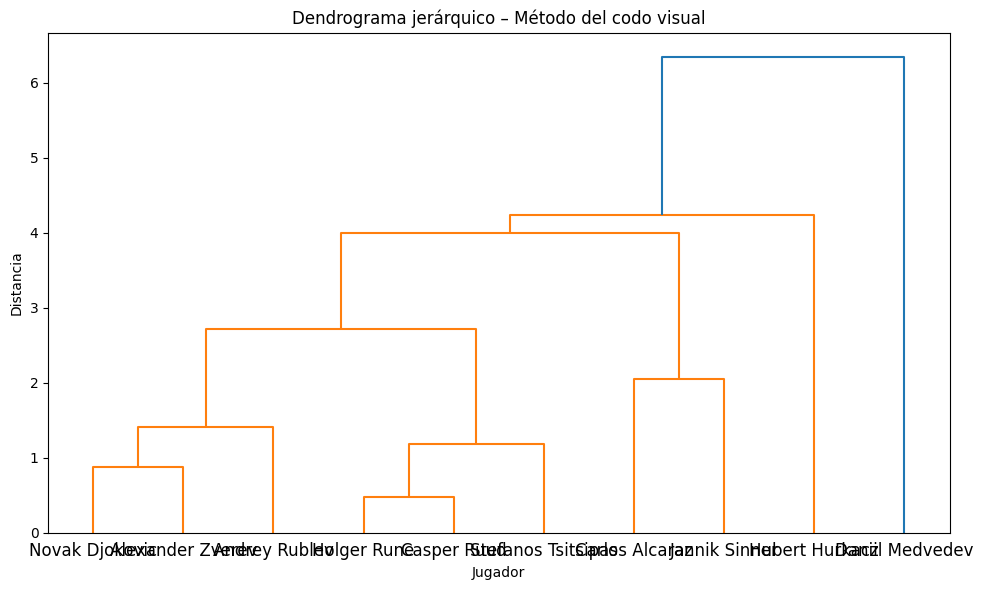

=== Silhouette Scores por k ===
k = 2 → Silhouette Score = 0.460
k = 3 → Silhouette Score = 0.296
k = 4 → Silhouette Score = 0.266
k = 5 → Silhouette Score = 0.246

=== Davies-Bouldin Index por k ===
k = 2 → DBI = 0.317
k = 3 → DBI = 0.360
k = 4 → DBI = 0.565
k = 5 → DBI = 0.599


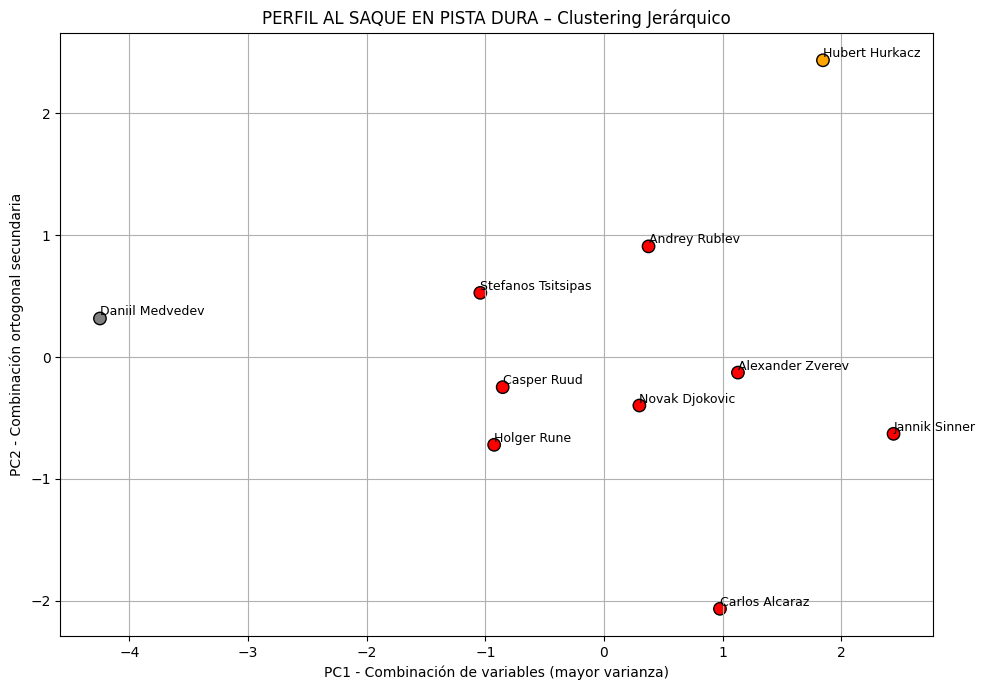


Cluster 0:
     Jannik Sinner
  Alexander Zverev
    Carlos Alcaraz
    Novak Djokovic
       Casper Ruud
       Holger Rune
     Andrey Rublev
Stefanos Tsitsipas

Cluster 1:
Daniil Medvedev

Cluster 2:
Hubert Hurkacz

=== Contribución de cada variable a PC1 y PC2 ===
           PC1     PC2
Ace%    0.2934  0.7258
DF%    -0.5023  0.0540
Hld%    0.5386 -0.1190
1st%    0.5064  0.1930
2%-InP  0.3392 -0.6472

Silhouette Score promedio (k=3): 0.296


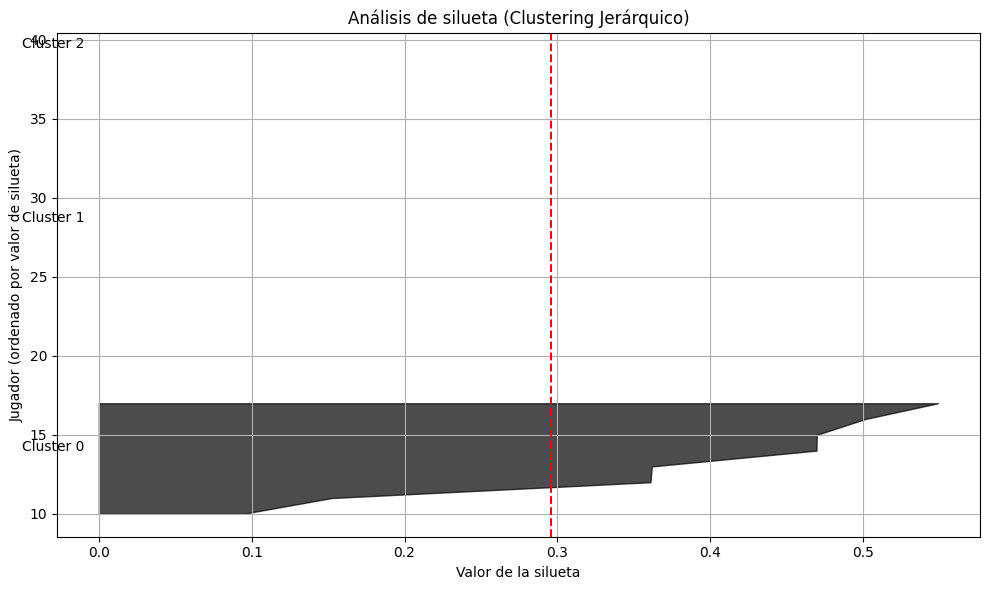


=== Silhouette por jugador ===
                Player  Cluster  Silhouette
10     Daniil Medvedev        1       0.000
30      Hubert Hurkacz        2       0.000
16       Andrey Rublev        0       0.094
0        Jannik Sinner        0       0.152
18  Stefanos Tsitsipas        0       0.361
1     Alexander Zverev        0       0.362
2       Carlos Alcaraz        0       0.469
9          Holger Rune        0       0.470
6          Casper Ruud        0       0.501
5       Novak Djokovic        0       0.549


In [123]:

# === 1. Filtrar top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 2. Definir todas las variables ===
variables_combinadas = ['Ace%', 'DF%', 'Hld%', '1st%', '2%-InP']

# === 3. Escalar todas las variables ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_top10[variables_combinadas])

# === 4. PCA conjunto con 2 componentes ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_top10['PC1'] = X_pca[:, 0]
df_top10['PC2'] = X_pca[:, 1]
X_custom = df_top10[['PC1', 'PC2']]

# === 5. MÉTODO DEL CODO (DENDROGRAMA) ===
linked = linkage(X_custom, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=df_top10['Player'].values, orientation='top',
           distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrograma jerárquico – Método del codo visual")
plt.xlabel("Jugador")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

# === 6. Silhouette Score por k (para elegir numéricamente) ===
print("=== Silhouette Scores por k ===")
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_custom)
    score = silhouette_score(X_custom, labels)
    print(f"k = {k} → Silhouette Score = {score:.3f}")

# === 6.1 Davies-Bouldin Index por k (añadido) ===
print("\n=== Davies-Bouldin Index por k ===")
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_custom)
    dbi = davies_bouldin_score(X_custom, labels)
    print(f"k = {k} → DBI = {dbi:.3f}")

# === 7. Clustering jerárquico con k óptimo ===
k_optimo = 3
model = AgglomerativeClustering(n_clusters=k_optimo)
df_top10['Cluster'] = model.fit_predict(X_custom)

# === 8. Visualización del clustering en 2D ===
colores_por_cluster = {0: 'red', 1: 'grey', 2: 'orange'}
df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PC1'], df_top10['PC2'], c=df_top10['Color'], s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['PC1'], row['PC2'], row['Player'], fontsize=9, va='bottom')

plt.xlabel("PC1 - Combinación de variables (mayor varianza)")
plt.ylabel("PC2 - Combinación ortogonal secundaria")
plt.title("PERFIL AL SAQUE EN PISTA DURA – Clustering Jerárquico")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

# === 10. Mostrar pesos (loadings) de cada variable ===
loading_df = pd.DataFrame(pca.components_, columns=variables_combinadas, index=['PC1', 'PC2']).T.round(4)
print("\n=== Contribución de cada variable a PC1 y PC2 ===")
print(loading_df)

# === 11. Silhouette Score y gráfico ===
silhouette_avg = silhouette_score(X_custom, df_top10['Cluster'])
print(f"\nSilhouette Score promedio (k={k_optimo}): {silhouette_avg:.3f}")
sample_silhouette_values = silhouette_samples(X_custom, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_sil = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_cluster_sil.sort()
    size_cluster = ith_cluster_sil.shape[0]
    y_upper = y_lower + size_cluster

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta (Clustering Jerárquico)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 12. Silueta por jugador (opcional) ===
df_top10['Silhouette'] = sample_silhouette_values
print("\n=== Silhouette por jugador ===")
print(df_top10[['Player', 'Cluster', 'Silhouette']].sort_values(by='Silhouette', ascending=True).round(3))


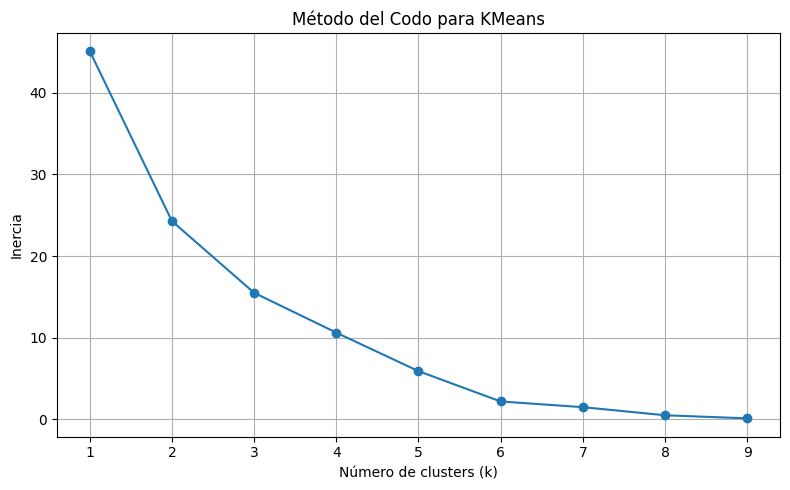

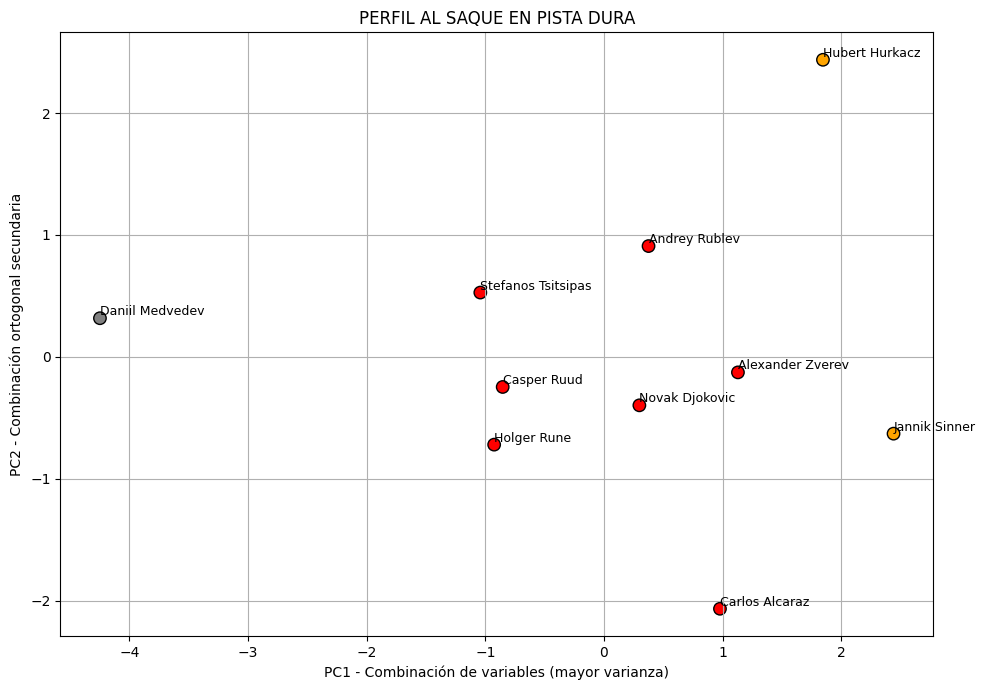


Cluster 0:
  Alexander Zverev
    Carlos Alcaraz
    Novak Djokovic
       Casper Ruud
       Holger Rune
     Andrey Rublev
Stefanos Tsitsipas

Cluster 1:
Daniil Medvedev

Cluster 2:
 Jannik Sinner
Hubert Hurkacz

=== Contribución de cada variable a PC1 y PC2 ===
           PC1     PC2
Ace%    0.2934  0.7258
DF%    -0.5023  0.0540
Hld%    0.5386 -0.1190
1st%    0.5064  0.1930
2%-InP  0.3392 -0.6472

Davies-Bouldin Index (DBI): 0.818


In [124]:


# === 1. Filtrar top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 2. Definir todas las variables ===
variables_combinadas = ['Ace%', 'DF%', 'Hld%', '1st%', '2%-InP']

# === 3. Escalar todas las variables ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_top10[variables_combinadas])

# === 4. PCA conjunto con 2 componentes ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === 5. Agregar componentes al DataFrame ===
df_top10['PC1'] = X_pca[:, 0]
df_top10['PC2'] = X_pca[:, 1]

# === 6. Técnica del Codo para encontrar el mejor k ===
X_custom = df_top10[['PC1', 'PC2']]
inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_custom)
    inertias.append(kmeans.inertia_)

# === 7. Graficar el método del codo ===
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xticks(k_range)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para KMeans')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Elegir k y aplicar KMeans ===
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_top10['Cluster'] = kmeans.fit_predict(X_custom)

# === 9. Visualización del clustering en 2D ===
colores_por_cluster = {
    0: 'red',
    1: 'grey',
    2: 'orange'
}

# Añade una nueva columna con el color correspondiente
df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PC1'], df_top10['PC2'], c=df_top10['Color'], s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['PC1'], row['PC2'], row['Player'], fontsize=9, va='bottom')

plt.xlabel("PC1 - Combinación de variables (mayor varianza)")
plt.ylabel("PC2 - Combinación ortogonal secundaria")
plt.title("PERFIL AL SAQUE EN PISTA DURA")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 10. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

# === 11. Mostrar pesos (loadings) de cada variable ===
loading_df = pd.DataFrame(pca.components_, columns=variables_combinadas, index=['PC1', 'PC2']).T.round(4)
print("\n=== Contribución de cada variable a PC1 y PC2 ===")
print(loading_df)

# === 12. Guardar clusters en diccionario si deseas usar luego ===
clusters_saque = dict(zip(df_top10['Player'], df_top10['Cluster']))

# === 13. Davies-Bouldin Index ===
dbi = davies_bouldin_score(X_custom, df_top10['Cluster'])
print(f"\nDavies-Bouldin Index (DBI): {dbi:.3f}")


CLUSTER 0: JUGADOR BUENO AL SERVICIO

CLUSTER 1: JUGADOR NORMAL AL SERVICIO

CLUSTER 2: JUGADOR PELIGROSO AL SERVICIO


Silhouette Score promedio: 0.262


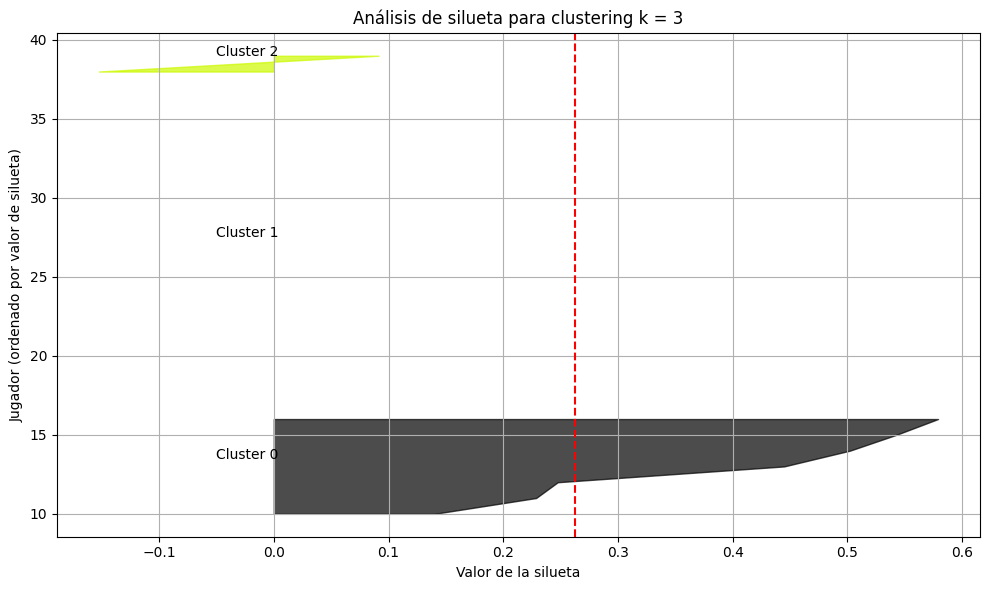

In [83]:
# === Silhouette Score global ===
silhouette_avg = silhouette_score(X_custom, df_top10['Cluster'])
print(f"\nSilhouette Score promedio: {silhouette_avg:.3f}")

# === Gráfico de silueta ===
sample_silhouette_values = silhouette_samples(X_custom, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_silhouette_values = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10  # espacio entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta para clustering k = {}".format(k_optimo))
plt.grid(True)
plt.tight_layout()
plt.show()

NO USAR EL SIGUIENTE

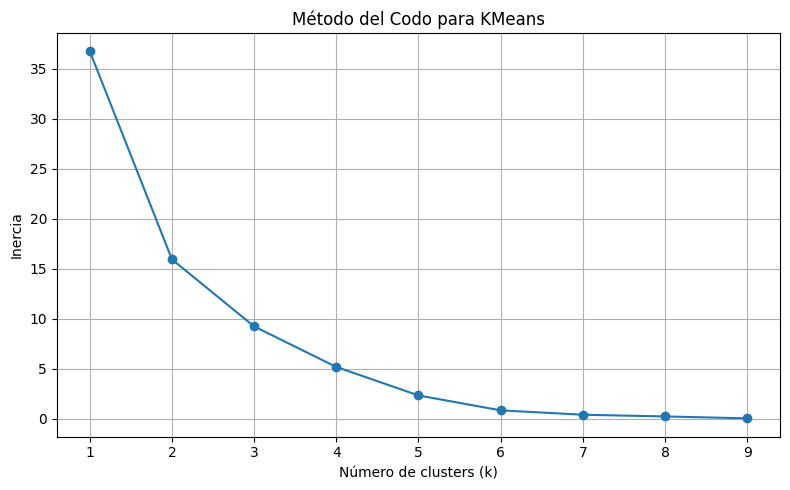

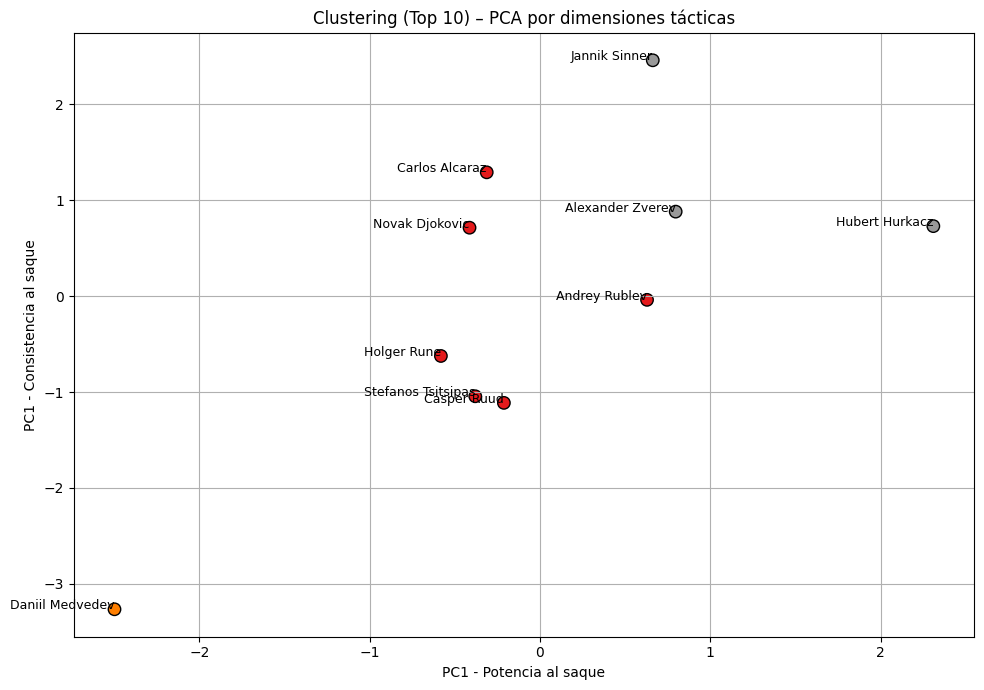


Cluster 0:
    Carlos Alcaraz
    Novak Djokovic
       Casper Ruud
       Holger Rune
     Andrey Rublev
Stefanos Tsitsipas

Cluster 1:
Daniil Medvedev

Cluster 2:
   Jannik Sinner
Alexander Zverev
  Hubert Hurkacz

=== Contribución de cada variable a PC1 (precision al saque) ===
Ace%    0.7071
DF%    -0.7071
dtype: float64

=== Contribución de cada variable a PC1 (consistencia al saque) ===
Hld%      0.6325
1st%      0.5784
2%-InP    0.5151
dtype: float64


In [178]:

df_top10 = df[df['Player'].isin(top10)].copy()

# === 2. Define tus dos grupos conceptuales de variables ===
# Grupo ofensivo / potencia al saque
variables_x = ['Ace%', 'DF%']  # Eje X

# Grupo de consistencia / defensa bajo presión
variables_y = ['Hld%', '1st%', '2%-InP']  # Eje Y

# === 3. Escalar cada grupo por separado ===
scaler_x = StandardScaler()
X_x_scaled = scaler_x.fit_transform(df_top10[variables_x])

scaler_y = StandardScaler()
X_y_scaled = scaler_y.fit_transform(df_top10[variables_y])

# === 4. PCA en cada grupo ===
pca_x = PCA(n_components=1)
pca_y = PCA(n_components=1)

PC1_x = pca_x.fit_transform(X_x_scaled).flatten()
PC1_y = pca_y.fit_transform(X_y_scaled).flatten()

# === 5. Agregar componentes al DataFrame ===
df_top10['PC1_X'] = PC1_x  # Potencia al saque
df_top10['PC1_Y'] = PC1_y  # Consistencia / presión

# === 6. Técnica del Codo para encontrar el mejor k ===
X_custom = df_top10[['PC1_X', 'PC1_Y']]
inertias = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_custom)
    inertias.append(kmeans.inertia_)

# === 7. Graficar el método del codo ===
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xticks(k_range)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para KMeans')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Elegir k y aplicar KMeans ===
k_optimo = 3  
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_top10['Cluster'] = kmeans.fit_predict(X_custom)

# === 9. Visualización del clustering ===
plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PC1_X'], df_top10['PC1_Y'], c=df_top10['Cluster'], cmap='Set1', s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['PC1_X'], row['PC1_Y'], row['Player'], fontsize=9, ha='right')

plt.xlabel("PC1 - Potencia al saque")
plt.ylabel("PC1 - Consistencia al saque")
plt.title("Clustering (Top 10) – PCA por dimensiones tácticas")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 10. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

# === 11. Mostrar pesos (loading) de cada variable en su componente ===
print("\n=== Contribución de cada variable a PC1 (precision al saque) ===")
print(pd.Series(pca_x.components_[0], index=variables_x).round(4))

print("\n=== Contribución de cada variable a PC1 (consistencia al saque) ===")
print(pd.Series(pca_y.components_[0], index=variables_y).round(4))

# === 12. Guardar clusters en diccionario si deseas usar luego ===
clusters_saque = dict(zip(df_top10['Player'], df_top10['Cluster']))


JUGADORES BUENOS AL SAQUE
JUGADORES NORMALES AL SAQUE
JUGADORES no destaca AL SAQUE

cluster 2: JUGADORES BUENOS AL SAQUE
cluster 0: JUGADORES NORMALES AL SAQUE
cluster 1: JUGADORES MALOS AL SAQUE

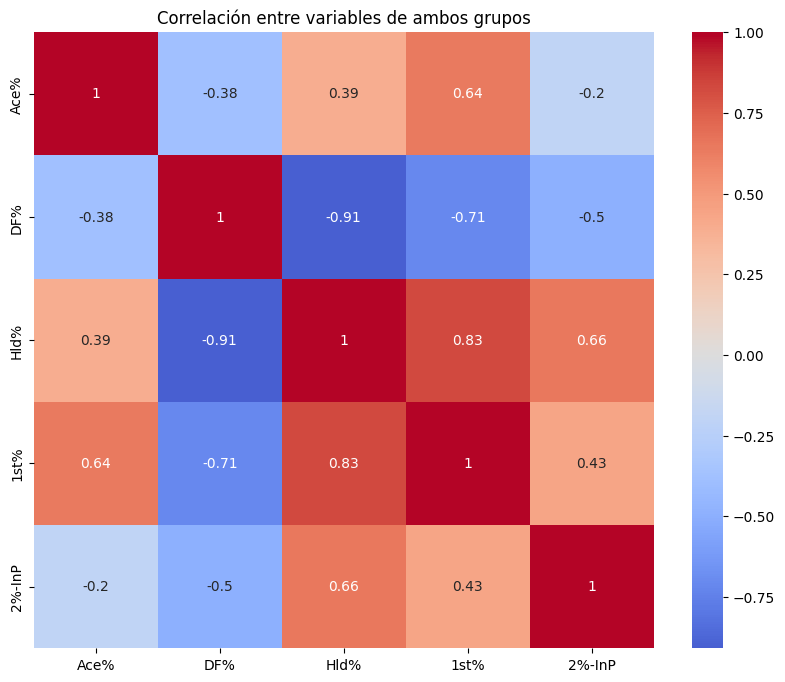

In [179]:
# Matriz de correlación entre grupos para ver independencia
corr_matrix = df_top10[variables_x + variables_y].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre variables de ambos grupos")
plt.show()

------------

-------------

--------------

RESTO

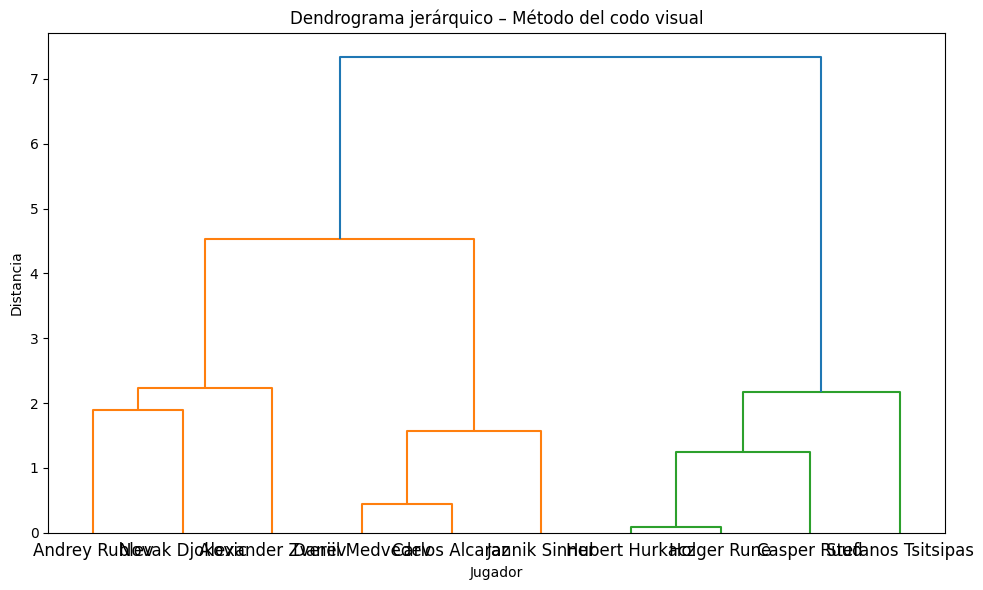


=== Silhouette Scores por k ===
k = 2 → Silhouette Score = 0.425
k = 3 → Silhouette Score = 0.422
k = 4 → Silhouette Score = 0.351
k = 5 → Silhouette Score = 0.364


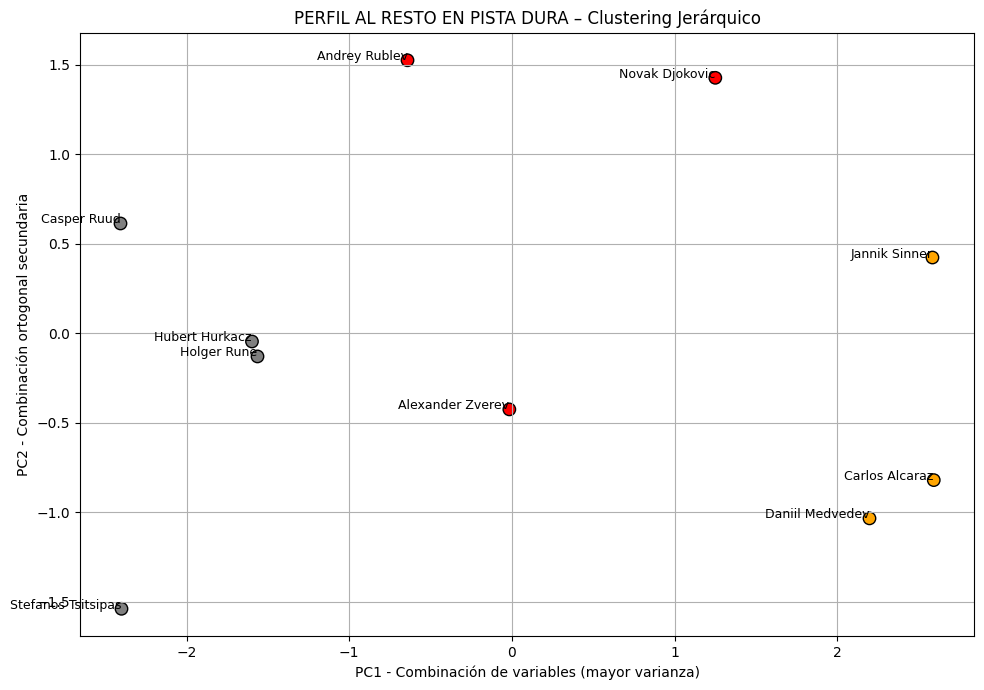


Cluster 0:
Alexander Zverev
  Novak Djokovic
   Andrey Rublev

Cluster 1:
       Casper Ruud
       Holger Rune
Stefanos Tsitsipas
    Hubert Hurkacz

Cluster 2:
  Jannik Sinner
 Carlos Alcaraz
Daniil Medvedev

=== Contribución de cada variable a PC1 y PC2 ===
           PC1     PC2
v1st%   0.5048 -0.2080
v2nd%   0.4381  0.5008
RPW     0.5083  0.0838
Pts/RG  0.4326  0.2442
vAce%  -0.3284  0.7996

Silhouette Score promedio: 0.422


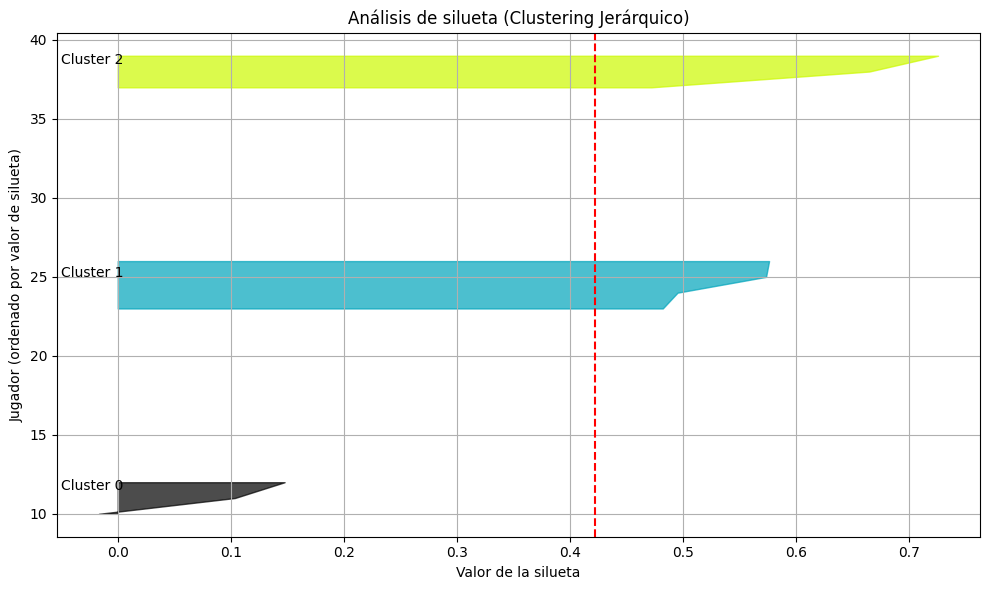


=== Silhouette por jugador ===
                Player  Cluster  Silhouette
1     Alexander Zverev        0      -0.017
5       Novak Djokovic        0       0.104
16       Andrey Rublev        0       0.148
0        Jannik Sinner        2       0.472
6          Casper Ruud        1       0.482
18  Stefanos Tsitsipas        1       0.495
9          Holger Rune        1       0.573
30      Hubert Hurkacz        1       0.576
10     Daniil Medvedev        2       0.665
2       Carlos Alcaraz        2       0.726

Davies-Bouldin Index (DBI): 0.773


In [125]:
# === 1. Filtrar top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 2. Definir todas las variables ===
variables_combinadas = ['v1st%', 'v2nd%', 'RPW', 'Pts/RG', 'vAce%']

# === 3. Escalar todas las variables ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_top10[variables_combinadas])

# === 4. PCA conjunto con 2 componentes ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === 5. Agregar componentes al DataFrame ===
df_top10['PC1'] = X_pca[:, 0]
df_top10['PC2'] = X_pca[:, 1]

# === 5.1 Método del codo para clustering jerárquico (Dendrograma) ===
linked = linkage(df_top10[['PC1', 'PC2']], method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, labels=df_top10['Player'].values, orientation='top',
           distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrograma jerárquico – Método del codo visual")
plt.xlabel("Jugador")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

# === 5.2 Evaluación con Silhouette Score por k (numérico) ===
print("\n=== Silhouette Scores por k ===")
for k in range(2, 6):
    model_temp = AgglomerativeClustering(n_clusters=k)
    labels = model_temp.fit_predict(df_top10[['PC1', 'PC2']])
    score = silhouette_score(df_top10[['PC1', 'PC2']], labels)
    print(f"k = {k} → Silhouette Score = {score:.3f}")

# === 6. Clustering jerárquico con k clusters ===
k_optimo = 3
model = AgglomerativeClustering(n_clusters=k_optimo)
df_top10['Cluster'] = model.fit_predict(df_top10[['PC1', 'PC2']])

# === 7. Visualización del clustering en 2D ===
colores_por_cluster = {
    0: 'red',
    1: 'grey',
    2: 'orange'
}
df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PC1'], df_top10['PC2'], c=df_top10['Color'], s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['PC1'], row['PC2'], row['Player'], fontsize=9, ha='right')

plt.xlabel("PC1 - Combinación de variables (mayor varianza)")
plt.ylabel("PC2 - Combinación ortogonal secundaria")
plt.title("PERFIL AL RESTO EN PISTA DURA – Clustering Jerárquico")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

# === 9. Mostrar pesos (loadings) de cada variable ===
loading_df = pd.DataFrame(pca.components_, columns=variables_combinadas, index=['PC1', 'PC2']).T.round(4)
print("\n=== Contribución de cada variable a PC1 y PC2 ===")
print(loading_df)

# === 10. Silhouette Score y gráfico ===
X_custom = df_top10[['PC1', 'PC2']]
silhouette_avg = silhouette_score(X_custom, df_top10['Cluster'])
print(f"\nSilhouette Score promedio: {silhouette_avg:.3f}")
sample_silhouette_values = silhouette_samples(X_custom, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_silhouette_values = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta (Clustering Jerárquico)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 11. Silueta por jugador ===
df_top10['Silhouette'] = sample_silhouette_values
print("\n=== Silhouette por jugador ===")
print(df_top10[['Player', 'Cluster', 'Silhouette']].sort_values(by='Silhouette', ascending=True).round(3))

# === 12. Davies-Bouldin Index ===
dbi = davies_bouldin_score(X_custom, df_top10['Cluster'])
print(f"\nDavies-Bouldin Index (DBI): {dbi:.3f}")

USAR EL SIGUIENTE

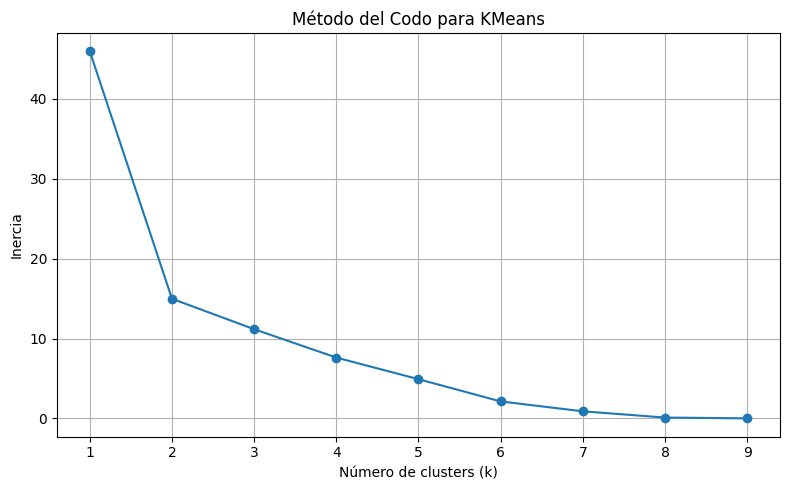

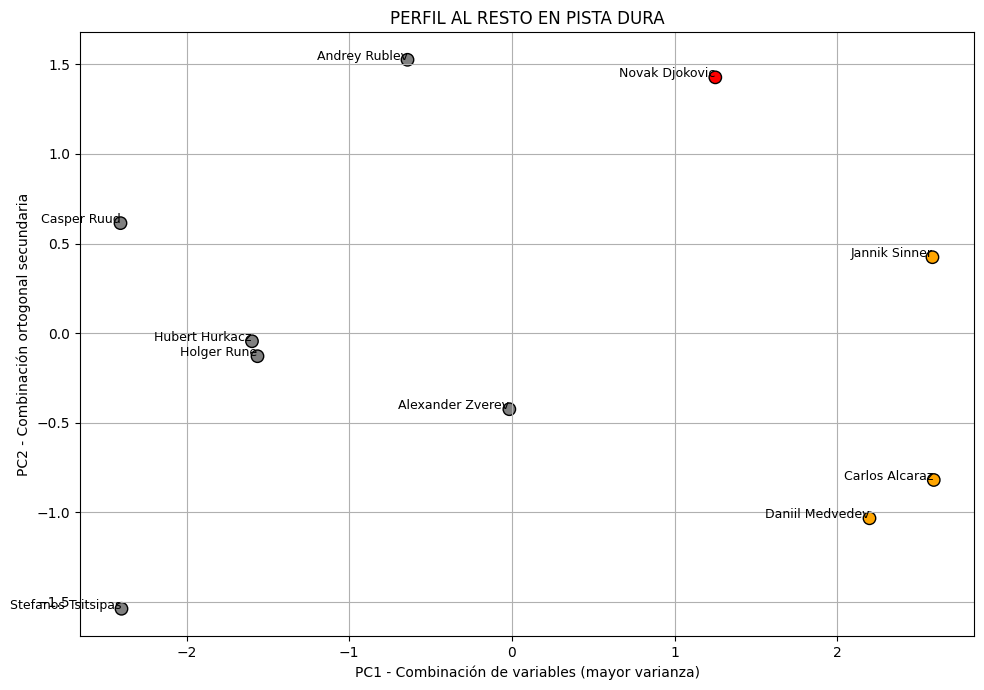


Cluster 0:
Novak Djokovic

Cluster 1:
  Alexander Zverev
       Casper Ruud
       Holger Rune
     Andrey Rublev
Stefanos Tsitsipas
    Hubert Hurkacz

Cluster 2:
  Jannik Sinner
 Carlos Alcaraz
Daniil Medvedev

=== Contribución de cada variable a PC1 y PC2 ===
           PC1     PC2
v1st%   0.5048 -0.2080
v2nd%   0.4381  0.5008
RPW     0.5083  0.0838
Pts/RG  0.4326  0.2442
vAce%  -0.3284  0.7996

Davies-Bouldin Index (DBI): 0.410


In [126]:
# === 1. Filtrar top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 2. Definir todas las variables ===
variables_combinadas = ['v1st%', 'v2nd%', 'RPW','Pts/RG', 'vAce%']

# === 3. Escalar todas las variables ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_top10[variables_combinadas])

# === 4. PCA conjunto con 2 componentes ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === 5. Agregar componentes al DataFrame ===
df_top10['PC1'] = X_pca[:, 0]
df_top10['PC2'] = X_pca[:, 1]

# === 6. Técnica del Codo para encontrar el mejor k ===
X_custom = df_top10[['PC1', 'PC2']]
inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_custom)
    inertias.append(kmeans.inertia_)

# === 7. Graficar el método del codo ===
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xticks(k_range)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para KMeans')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Elegir k y aplicar KMeans ===
k_optimo = 3
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_top10['Cluster'] = kmeans.fit_predict(X_custom)

# === 9. Visualización del clustering en 2D ===
colores_por_cluster = {
    0: 'red',
    1: 'grey',
    2: 'orange'
}

# Añade una nueva columna con el color correspondiente
df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PC1'], df_top10['PC2'], c=df_top10['Color'], s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['PC1'], row['PC2'], row['Player'], fontsize=9, ha='right')

plt.xlabel("PC1 - Combinación de variables (mayor varianza)")
plt.ylabel("PC2 - Combinación ortogonal secundaria")
plt.title("PERFIL AL RESTO EN PISTA DURA")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 10. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

# === 11. Mostrar pesos (loadings) de cada variable ===
loading_df = pd.DataFrame(pca.components_, columns=variables_combinadas, index=['PC1', 'PC2']).T.round(4)
print("\n=== Contribución de cada variable a PC1 y PC2 ===")
print(loading_df)

# === 12. Guardar clusters en diccionario si deseas usar luego ===
clusters_resto = dict(zip(df_top10['Player'], df_top10['Cluster']))

# === 13. Davies-Bouldin Index ===
dbi = davies_bouldin_score(X_custom, df_top10['Cluster'])
print(f"\nDavies-Bouldin Index (DBI): {dbi:.3f}")

CLUSTER 0: JUGADOR BUENO AL RESTO

CLUSTER 1: JUGADOR NORMAL AL RESTO

CLUSTER 2: JUGADOR PELIGROSO AL RESTO


Silhouette Score promedio: 0.363


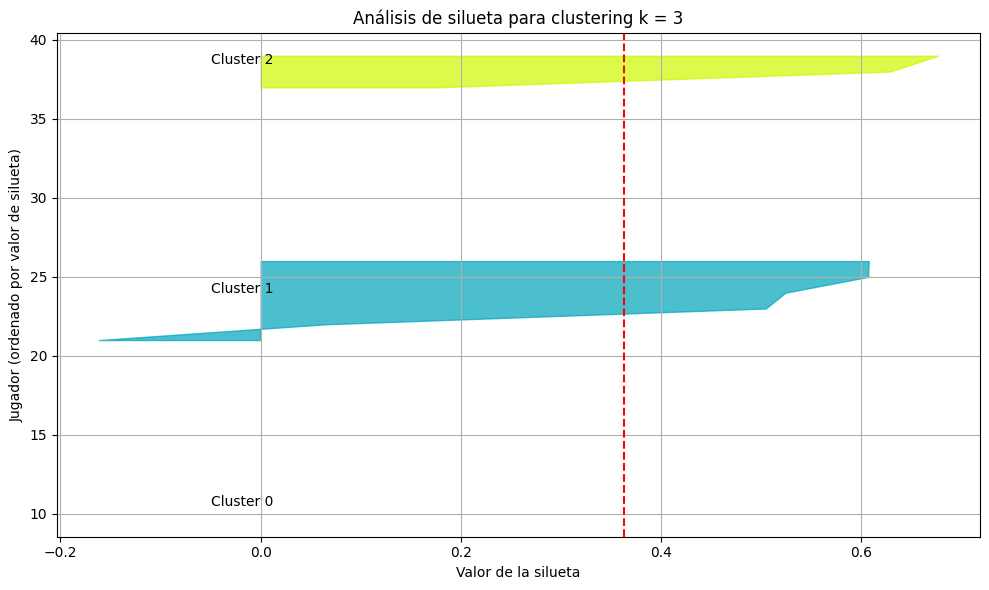

In [127]:
# === Silhouette Score global ===
silhouette_avg = silhouette_score(X_custom, df_top10['Cluster'])
print(f"\nSilhouette Score promedio: {silhouette_avg:.3f}")

# === Gráfico de silueta ===
sample_silhouette_values = silhouette_samples(X_custom, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_silhouette_values = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10  # espacio entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta para clustering k = {}".format(k_optimo))
plt.grid(True)
plt.tight_layout()
plt.show()

NO USAR EL SIGUIENTE

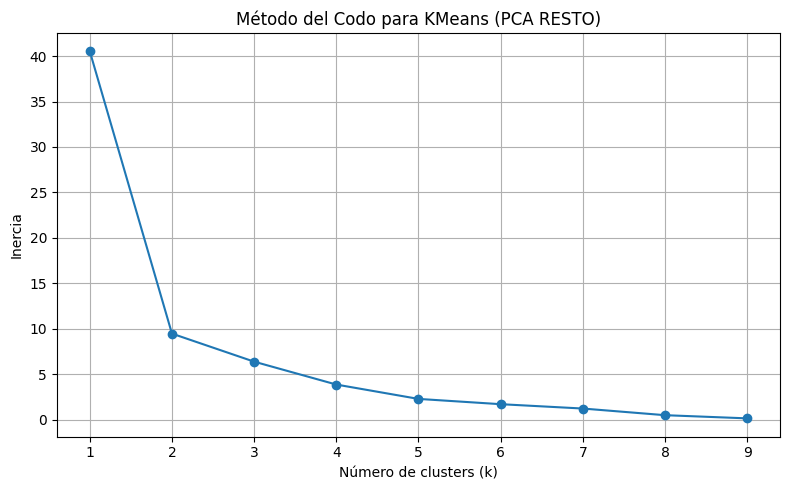

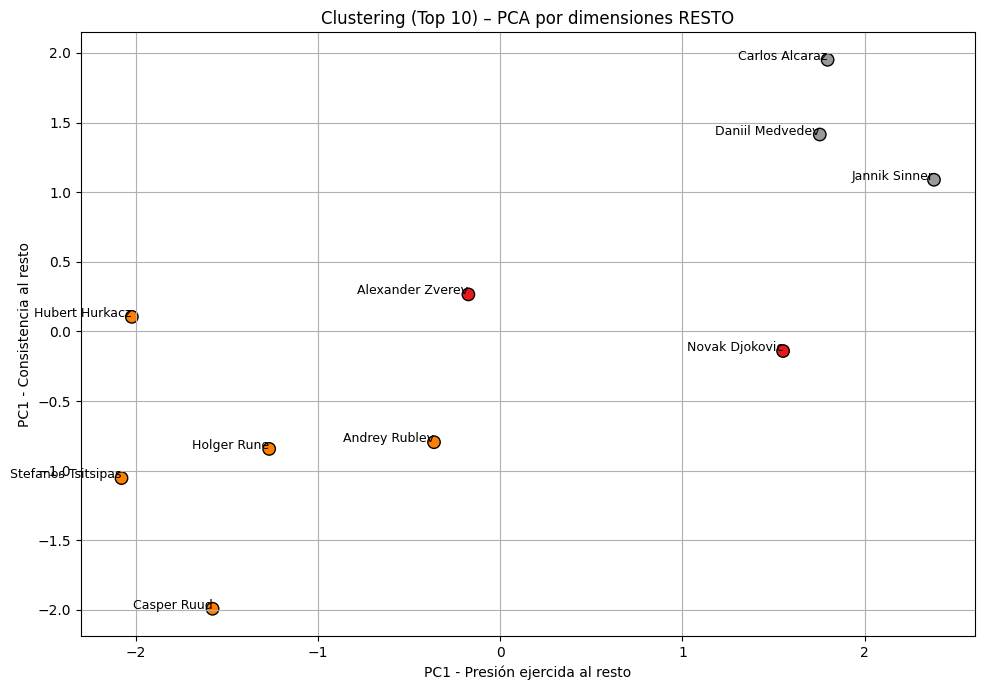


Cluster 0:
Alexander Zverev
  Novak Djokovic

Cluster 1:
       Casper Ruud
       Holger Rune
     Andrey Rublev
Stefanos Tsitsipas
    Hubert Hurkacz

Cluster 2:
  Jannik Sinner
 Carlos Alcaraz
Daniil Medvedev

=== Contribución de cada variable a PC1 (potencia al saque) ===
v1st%    0.5688
v2nd%    0.5552
RPW      0.6069
dtype: float64

=== Contribución de cada variable a PC1 (consistencia bajo presión) ===
Pts/RG    0.7071
vAce%    -0.7071
dtype: float64


In [175]:
# === 1. Filtrar solo los jugadores top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 2. Define tus dos grupos conceptuales de variables ===
variables_x = ['v1st%', 'v2nd%', 'RPW']  # Eje X
variables_y = ['Pts/RG', 'vAce%']    # Eje Y

# === 3. Escalar cada grupo por separado ===
scaler_x = StandardScaler()
X_x_scaled = scaler_x.fit_transform(df_top10[variables_x])

scaler_y = StandardScaler()
X_y_scaled = scaler_y.fit_transform(df_top10[variables_y])

# === 4. PCA en cada grupo ===
pca_x = PCA(n_components=1)
pca_y = PCA(n_components=1)

PC1_x = pca_x.fit_transform(X_x_scaled).flatten()
PC1_y = pca_y.fit_transform(X_y_scaled).flatten()

# === 5. Agregar componentes al DataFrame ===
df_top10['PC1_X'] = PC1_x
df_top10['PC1_Y'] = PC1_y

# === 6. Método del codo ===
X_custom = df_top10[['PC1_X', 'PC1_Y']]
inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    kmeans_tmp.fit(X_custom)
    inertias.append(kmeans_tmp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Método del Codo para KMeans (PCA RESTO)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. Clustering con número elegido (por ejemplo k=3) ===
kmeans = KMeans(n_clusters=3, random_state=42)
df_top10['Cluster'] = kmeans.fit_predict(X_custom)

# === 8. Gráfico personalizado ===
plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PC1_X'], df_top10['PC1_Y'], c=df_top10['Cluster'], cmap='Set1', s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['PC1_X'], row['PC1_Y'], row['Player'], fontsize=9, ha='right')

plt.xlabel("PC1 - Presión ejercida al resto")
plt.ylabel("PC1 - Consistencia al resto")
plt.title("Clustering (Top 10) – PCA por dimensiones RESTO")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

# === 10. Mostrar pesos (loading) de cada variable en su componente ===
print("\n=== Contribución de cada variable a PC1 (potencia al saque) ===")
print(pd.Series(pca_x.components_[0], index=variables_x).round(4))

print("\n=== Contribución de cada variable a PC1 (consistencia bajo presión) ===")
print(pd.Series(pca_y.components_[0], index=variables_y).round(4))

# === 11. Guardar los clusters en un diccionario ===
clusters_resto = dict(zip(df_top10['Player'], df_top10['Cluster']))

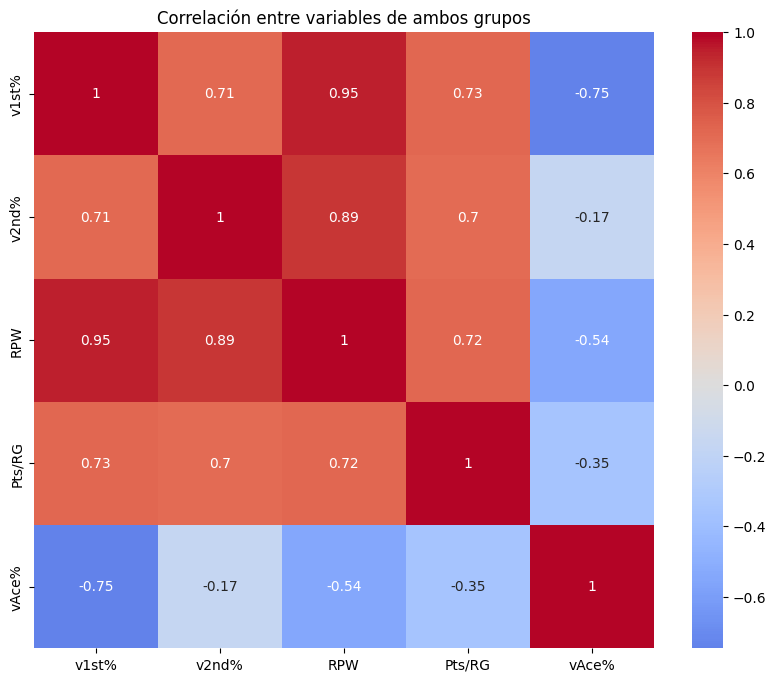

In [176]:
# Matriz de correlación entre grupos para ver independencia
corr_matrix = df_top10[variables_x + variables_y].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre variables de ambos grupos")
plt.show()


cluster 0: BUENOS AL RESTO
cluster 1: NORMALES AL RESTO
CLUSTER 2: MUY BUENOS AL RESTO




-------

BREAKS RESTOOOOOO

USAR EL SIGUIENTE

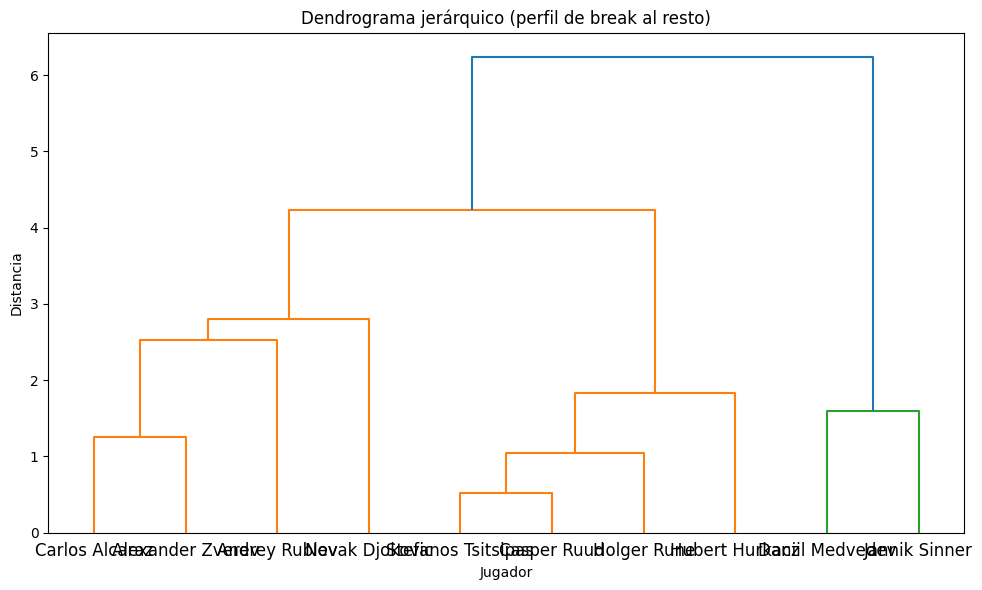

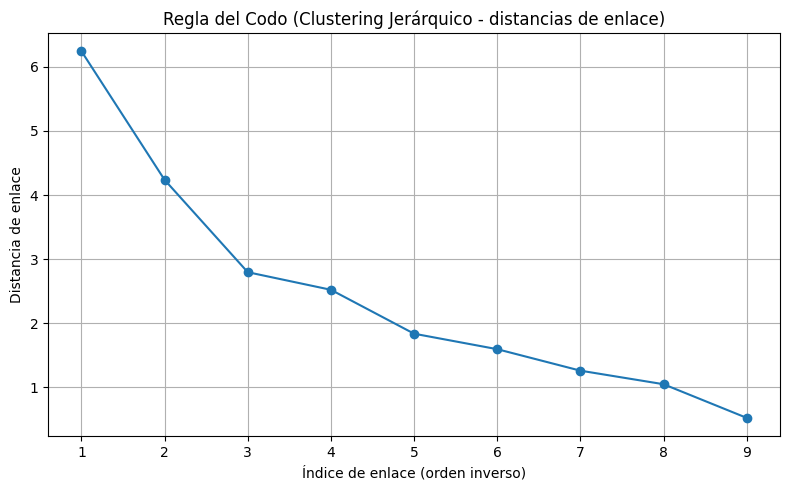

=== Silhouette Scores por k ===
k = 2 → Silhouette Score = 0.404
k = 3 → Silhouette Score = 0.370
k = 4 → Silhouette Score = 0.334
k = 5 → Silhouette Score = 0.313


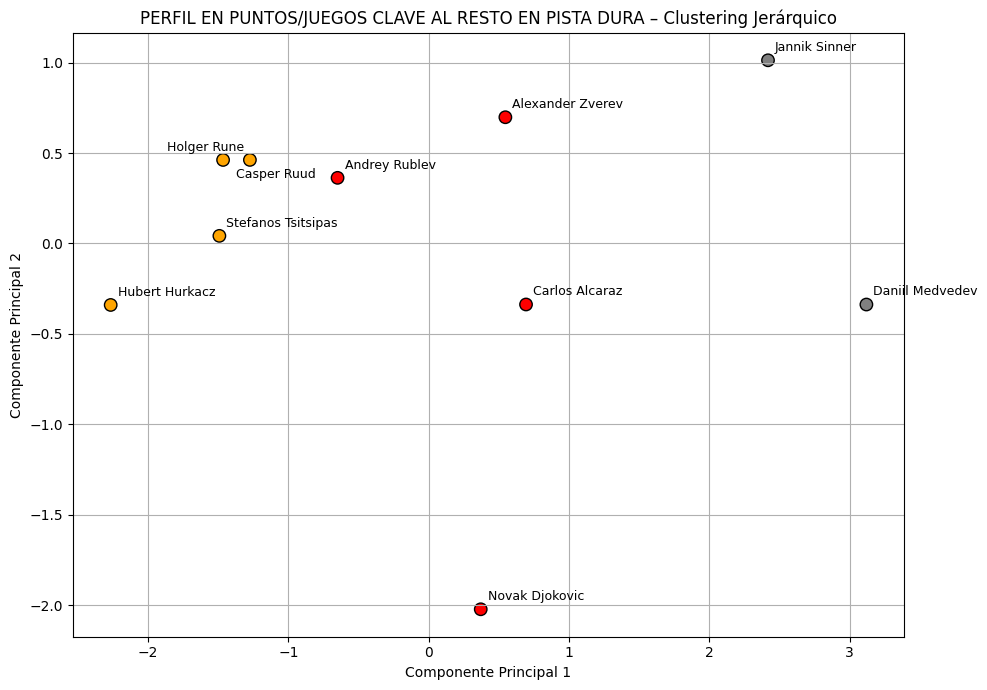


Silhouette Score promedio (k=3): 0.370


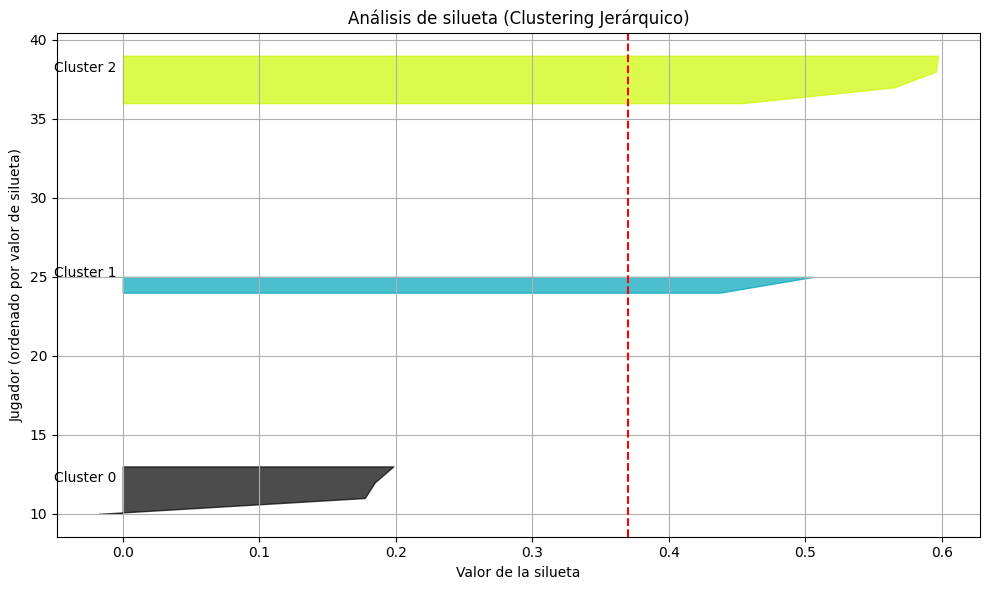

Davies-Bouldin Index (k=3): 0.929

Cluster 0:
Alexander Zverev
  Carlos Alcaraz
  Novak Djokovic
   Andrey Rublev

Cluster 1:
  Jannik Sinner
Daniil Medvedev

Cluster 2:
       Casper Ruud
       Holger Rune
Stefanos Tsitsipas
    Hubert Hurkacz


In [128]:
# === 3. Filtrar solo los top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 4. Variables del perfil de breaks ===
variables_break = ['BPConv%', 'BPChnc', 'Bks/M', 'BP/M']
X = df_top10[variables_break]

# === 5. Normalización ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 6. PCA a 2 componentes ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_top10['PCA1'] = X_pca[:, 0]
df_top10['PCA2'] = X_pca[:, 1]

# === 7. Dendrograma para estimar k ===
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=df_top10['Player'].values, orientation='top',
           distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrograma jerárquico (perfil de break al resto)")
plt.xlabel("Jugador")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

# === 7.1 Regla del codo para clustering jerárquico (distancias entre enlaces) ===
last = linked[-10:, 2]  # Últimos 10 enlaces
last_rev = last[::-1]
idxs = np.arange(1, len(last_rev) + 1)

plt.figure(figsize=(8, 5))
plt.plot(idxs, last_rev, marker='o')
plt.title("Regla del Codo (Clustering Jerárquico - distancias de enlace)")
plt.xlabel("Índice de enlace (orden inverso)")
plt.ylabel("Distancia de enlace")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 8. Silhouette Score para diferentes k ===
print("=== Silhouette Scores por k ===")
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k = {k} → Silhouette Score = {score:.3f}")

# === 9. Aplicar clustering jerárquico con k óptimo ===
k_optimo = 3
model = AgglomerativeClustering(n_clusters=k_optimo)
df_top10['Cluster'] = model.fit_predict(X_scaled)

# === 10. Gráfico 2D con etiquetas desplazadas ===
colores_por_cluster = {0: 'red', 1: 'grey', 2: 'orange'}
df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PCA1'], df_top10['PCA2'], c=df_top10['Color'], s=80, edgecolor='k')

coords = df_top10[['PCA1', 'PCA2']].to_numpy()
dist_matrix = squareform(pdist(coords))
threshold = 0.2
offsets = {}

for i, (x, y, name) in enumerate(zip(df_top10['PCA1'], df_top10['PCA2'], df_top10['Player'])):
    dx, dy = 0.05, 0.05
    for j in range(len(dist_matrix)):
        if i != j and dist_matrix[i, j] < threshold:
            dx, dy = (-0.1, -0.1) if i < j else (-0.4, 0.05)
            break
    offsets[name] = (dx, dy)
    plt.text(x + dx, y + dy, name, fontsize=9)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PERFIL EN PUNTOS/JUEGOS CLAVE AL RESTO EN PISTA DURA – Clustering Jerárquico")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 11. Silhouette Score global y gráfico ===
silhouette_avg = silhouette_score(X_scaled, df_top10['Cluster'])
print(f"\nSilhouette Score promedio (k={k_optimo}): {silhouette_avg:.3f}")

sample_silhouette_values = silhouette_samples(X_scaled, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_sil = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_sil.sort()
    size = ith_sil.shape[0]
    y_upper = y_lower + size

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta (Clustering Jerárquico)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 11.1 Davies-Bouldin Index ===
dbi = davies_bouldin_score(X_scaled, df_top10['Cluster'])
print(f"Davies-Bouldin Index (k={k_optimo}): {dbi:.3f}")

# === 12. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

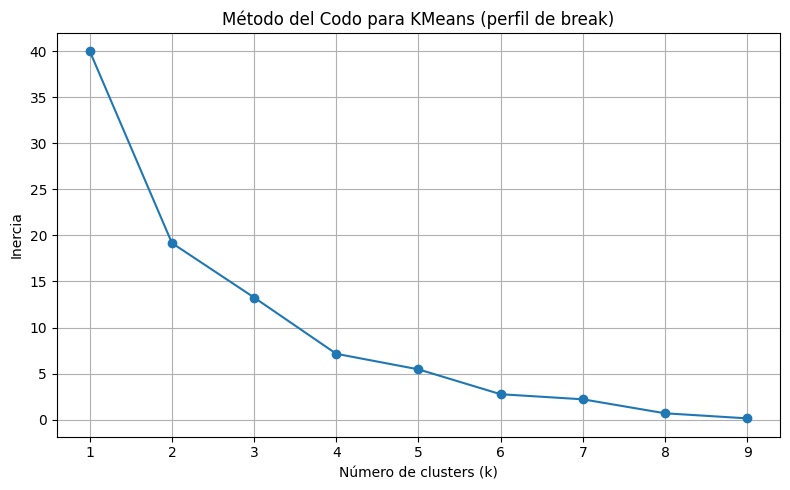

Davies-Bouldin Index (k=3): 0.915


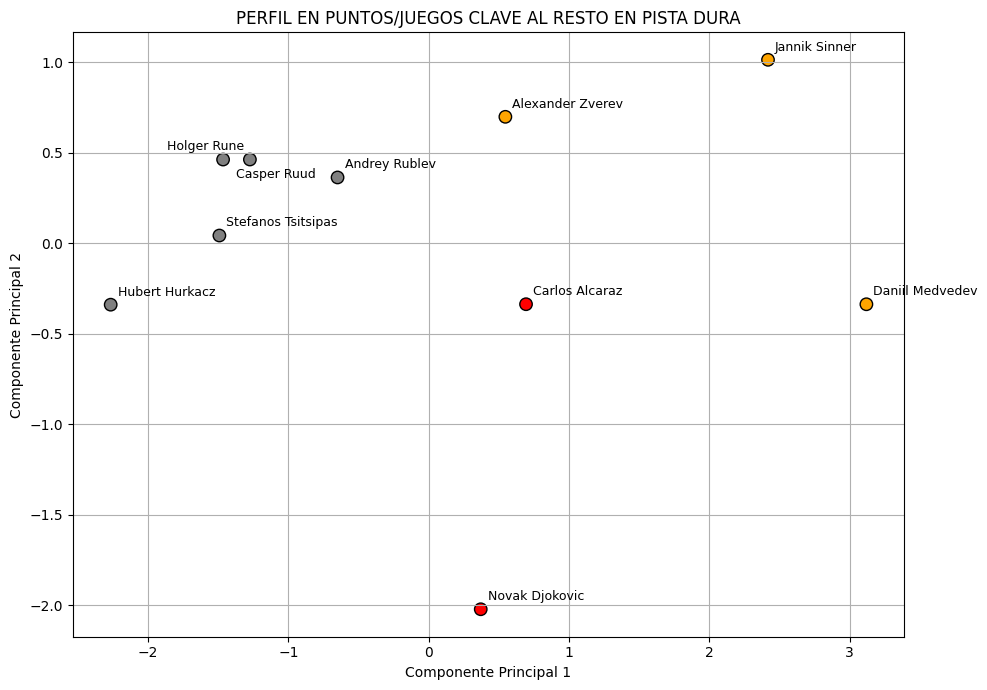


Cluster 0:
Carlos Alcaraz
Novak Djokovic

Cluster 1:
       Casper Ruud
       Holger Rune
     Andrey Rublev
Stefanos Tsitsipas
    Hubert Hurkacz

Cluster 2:
   Jannik Sinner
Alexander Zverev
 Daniil Medvedev


In [130]:
# === 3. Filtrar solo los top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 4. Variables del perfil de breaks ===
variables_break = ['BPConv%', 'BPChnc', 'Bks/M', 'BP/M']
X = df_top10[variables_break]

# === 5. Normalización ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 6. PCA a 2 componentes ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === 6.1 MÉTODO DEL CODO ===
inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Método del Codo para KMeans (perfil de break)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. KMeans sobre los 10 jugadores (elige k=3 o lo que el codo indique) ===
kmeans = KMeans(n_clusters=3, random_state=42)
df_top10['Cluster'] = kmeans.fit_predict(X_scaled)

# === 7.1 Davies-Bouldin Index ===
dbi = davies_bouldin_score(X_scaled, df_top10['Cluster'])
print(f"Davies-Bouldin Index (k=3): {dbi:.3f}")

# === 8. Agregar PCA al DataFrame ===
df_top10['PCA1'] = X_pca[:, 0]
df_top10['PCA2'] = X_pca[:, 1]

# === 9. Gráfico ===
colores_por_cluster = {
    0: 'red',
    1: 'grey',
    2: 'orange'
}

# Añade una nueva columna con el color correspondiente
df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['PCA1'], df_top10['PCA2'], c=df_top10['Color'], s=80, edgecolor='k')

# Matriz de distancias entre puntos
coords = df_top10[['PCA1', 'PCA2']].to_numpy()
dist_matrix = squareform(pdist(coords))

# Umbral para considerar dos puntos "cercanos"
threshold = 0.2

# Guardar desplazamientos aplicados
offsets = {}

# Etiquetar cada jugador
for i, (x, y, name) in enumerate(zip(df_top10['PCA1'], df_top10['PCA2'], df_top10['Player'])):
    dx, dy = 0.05, 0.05
    for j in range(len(dist_matrix)):
        if i != j and dist_matrix[i, j] < threshold:
            dx, dy = (-0.1, -0.1) if i < j else (-0.4, 0.05)
            break
    offsets[name] = (dx, dy)
    plt.text(x + dx, y + dy, name, fontsize=9)

plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.title("PERFIL EN PUNTOS/JUEGOS CLAVE AL RESTO EN PISTA DURA")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 10. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

# === 11. Guardar los clusters en un diccionario ===
clusters_break_resto = dict(zip(df_top10['Player'], df_top10['Cluster']))



CLUSTER 0: JUGADOR BUENO EN PUNTOS/JUEGOS CLAVE AL RESTO

CLUSTER 1: JUGADOR NORMAL EN PUNTOS/JUEGOS CLAVE AL RESTO

CLUSTER 2: JUGADOR PELIGROSO EN PUNTOS/JUEGOS CLAVE AL RESTO


In [119]:
# === Mostrar pesos de las variables en cada componente ===
pca_weights = pd.DataFrame(
    pca.components_,
    columns=variables_break,
    index=['Componente 1', 'Componente 2']
).T  # Transponemos para ver variables como filas

print("\n=== Peso de cada variable en las componentes principales ===")
print(pca_weights.round(4))


=== Peso de cada variable en las componentes principales ===
         Componente 1  Componente 2
BPConv%        0.4574        0.2173
BPChnc         0.4142        0.7998
Bks/M          0.5758       -0.3216
BP/M           0.5364       -0.4578



Silhouette Score promedio: 0.129


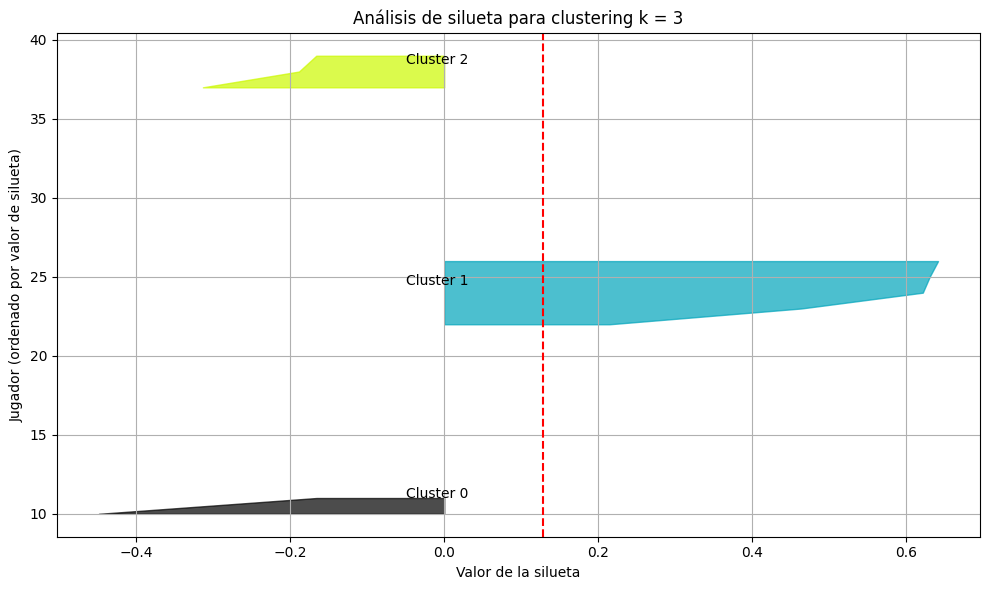

In [131]:
# === Silhouette Score global ===
silhouette_avg = silhouette_score(X_custom, df_top10['Cluster'])
print(f"\nSilhouette Score promedio: {silhouette_avg:.3f}")

# === Gráfico de silueta ===
sample_silhouette_values = silhouette_samples(X_custom, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_silhouette_values = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
    y_lower = y_upper + 10  # espacio entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta para clustering k = {}".format(k_optimo))
plt.grid(True)
plt.tight_layout()
plt.show()

%bp convertidas, mas es mejor
oportunidades de break, mas significa que tienes muchas
Bks/M, return game won
BP/M break points que tiene por partido

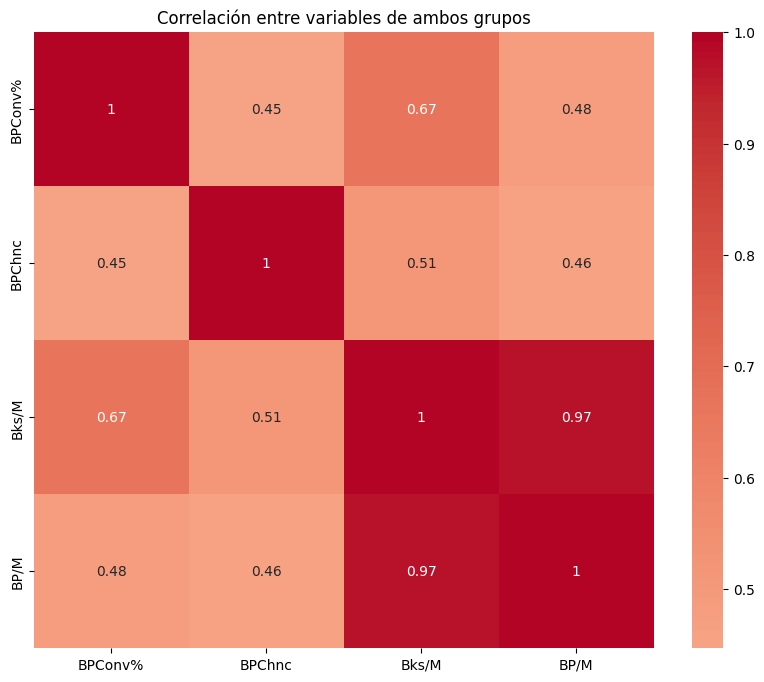

In [183]:
# Matriz de correlación entre grupos para ver independencia
corr_matrix = df_top10[variables_break].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlación entre variables de ambos grupos")
plt.show()

no tiene sentido hacer pca para solo 2 variables

BREAK SAQUE

USAR LA SIGUIENTE

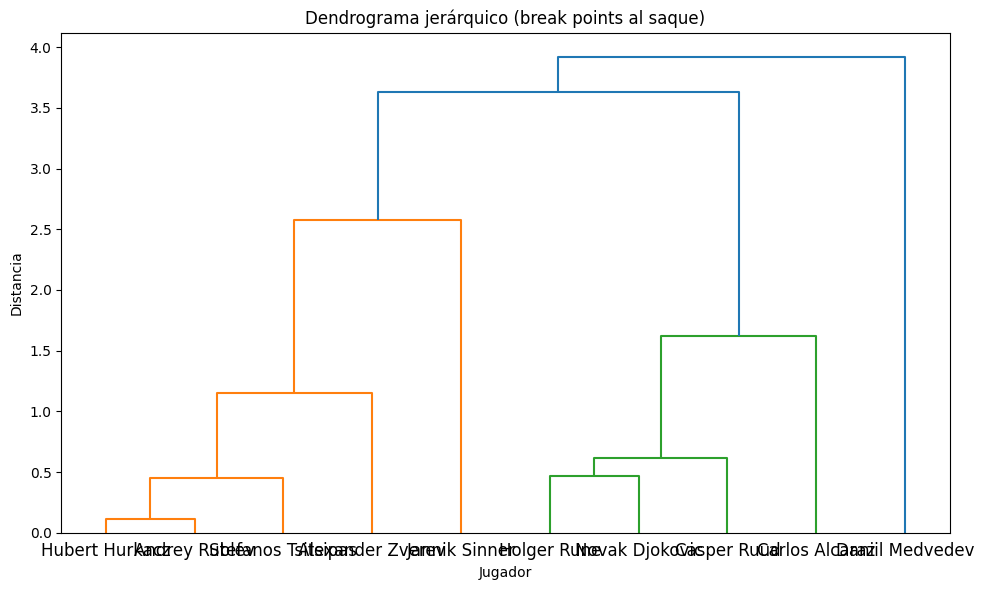

=== Silhouette Scores por k ===
k = 2 → Silhouette Score = 0.435
k = 3 → Silhouette Score = 0.406
k = 4 → Silhouette Score = 0.415
k = 5 → Silhouette Score = 0.380


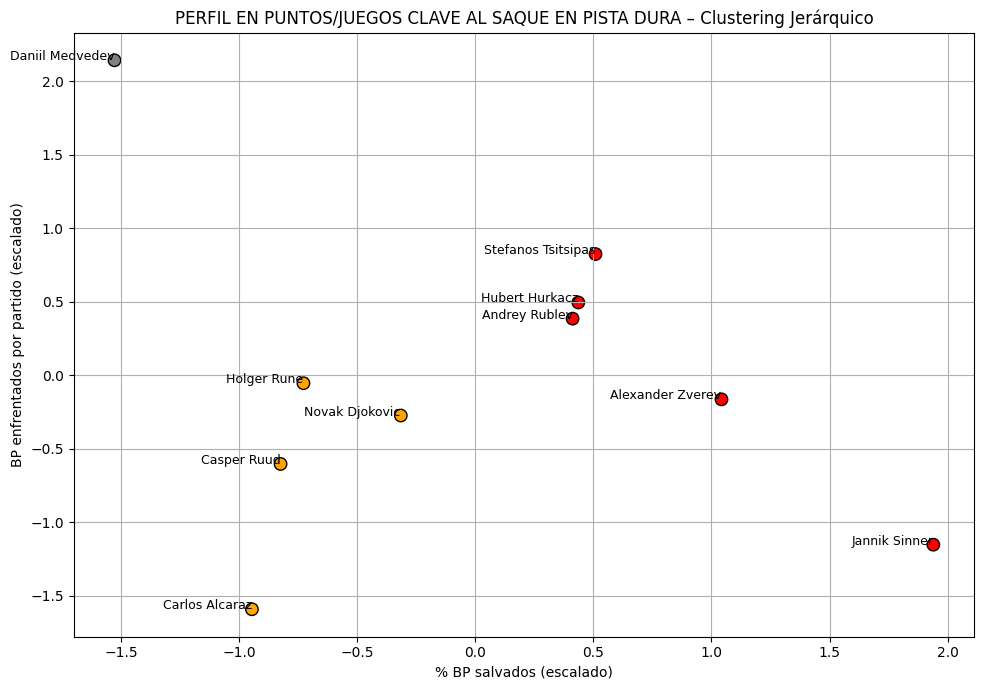


Silhouette Score promedio (k=3): 0.406
Davies-Bouldin Index (k=3): 0.600


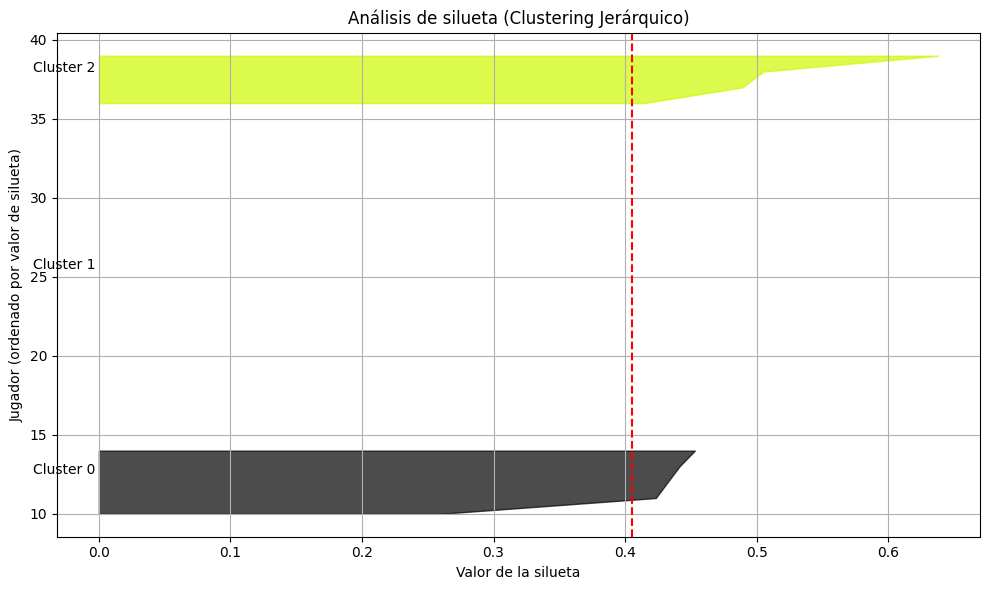


Cluster 0:
     Jannik Sinner
  Alexander Zverev
     Andrey Rublev
Stefanos Tsitsipas
    Hubert Hurkacz

Cluster 1:
Daniil Medvedev

Cluster 2:
Carlos Alcaraz
Novak Djokovic
   Casper Ruud
   Holger Rune


In [134]:
# === 3. Filtrar solo los top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 4. Variables del perfil de breaks al saque ===
variables_breakser = ['BPSvd%', 'BPvs/M']
X = df_top10[variables_breakser]

# === 5. Normalización ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 5.1 Dendrograma para estimar k ===
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=df_top10['Player'].values, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrograma jerárquico (break points al saque)")
plt.xlabel("Jugador")
plt.ylabel("Distancia")
plt.tight_layout()
plt.show()

# === 5.2 Silhouette Score para diferentes k ===
print("=== Silhouette Scores por k ===")
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k = {k} → Silhouette Score = {score:.3f}")

# === 6. Agglomerative Clustering con k óptimo ===
k_optimo = 3
model = AgglomerativeClustering(n_clusters=k_optimo)
df_top10['Cluster'] = model.fit_predict(X_scaled)

# === 7. Agregar variables escaladas para graficar ===
df_top10['BPSvd%_scaled'] = X_scaled[:, 0]
df_top10['BPvs/M_scaled'] = X_scaled[:, 1]

# === 8. Visualización 2D ===
colores_por_cluster = {
    0: 'red',
    1: 'grey',
    2: 'orange'
}

df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['BPSvd%_scaled'], df_top10['BPvs/M_scaled'], c=df_top10['Color'], s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['BPSvd%_scaled'], row['BPvs/M_scaled'], row['Player'], fontsize=9, ha='right')

plt.xlabel("% BP salvados (escalado)")
plt.ylabel("BP enfrentados por partido (escalado)")
plt.title("PERFIL EN PUNTOS/JUEGOS CLAVE AL SAQUE EN PISTA DURA – Clustering Jerárquico")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Silhouette por jugador ===
silhouette_avg = silhouette_score(X_scaled, df_top10['Cluster'])
print(f"\nSilhouette Score promedio (k={k_optimo}): {silhouette_avg:.3f}")

# === 9.1 Davies-Bouldin Index ===
dbi = davies_bouldin_score(X_scaled, df_top10['Cluster'])
print(f"Davies-Bouldin Index (k={k_optimo}): {dbi:.3f}")

sample_silhouette_values = silhouette_samples(X_scaled, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_sil = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_cluster_sil.sort()
    size_cluster = ith_cluster_sil.shape[0]
    y_upper = y_lower + size_cluster

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta (Clustering Jerárquico)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 10. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))

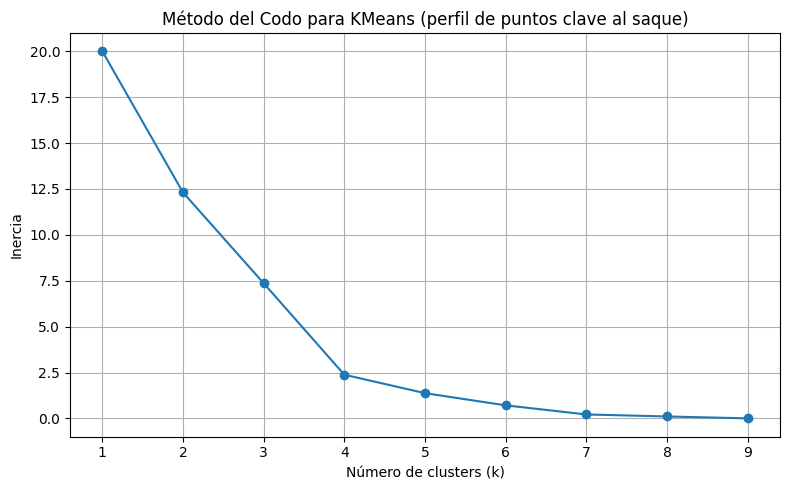


Silhouette Score promedio (k=3): 0.304
Davies-Bouldin Index (k=3): 0.681


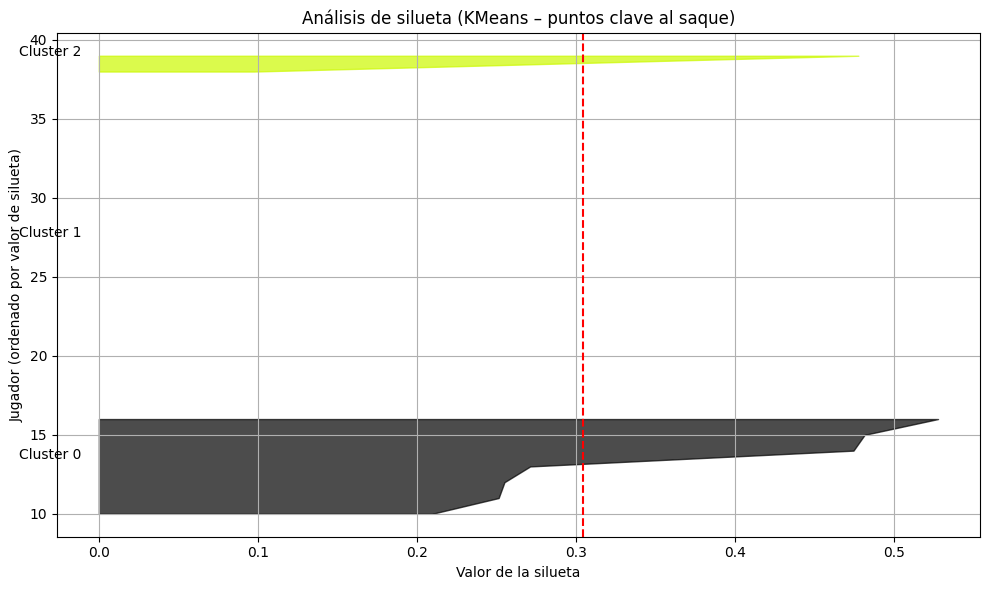

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15272\2612656001.py:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_top10['BPSvd%_scaled'], df_top10['BPvs/M_scaled'],


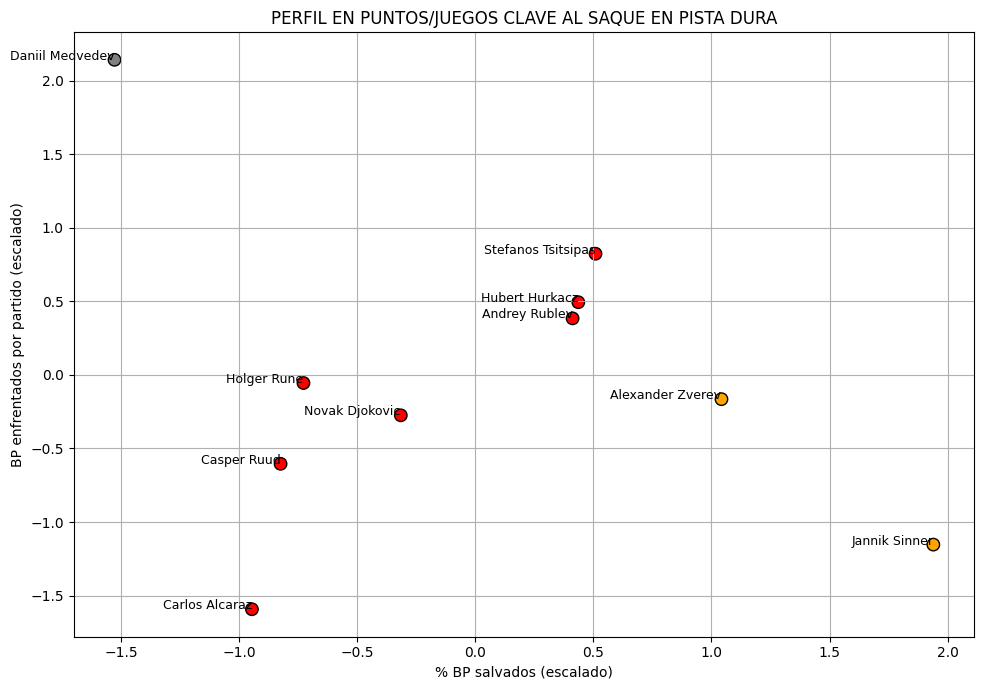


Cluster 0:
    Carlos Alcaraz
    Novak Djokovic
       Casper Ruud
       Holger Rune
     Andrey Rublev
Stefanos Tsitsipas
    Hubert Hurkacz

Cluster 1:
Daniil Medvedev

Cluster 2:
   Jannik Sinner
Alexander Zverev


In [135]:
# === 3. Filtrar solo los top 10 ===
df_top10 = df[df['Player'].isin(top10)].copy()

# === 4. Variables del perfil de breaks ===
variables_breakser = ['BPSvd%', 'BPvs/M']
X = df_top10[variables_breakser]

# === 5. Normalización ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 5.1 Método del codo ===
inertias = []
k_range = range(1, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Método del Codo para KMeans (perfil de puntos clave al saque)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. KMeans sobre los 10 jugadores ===
kmeans = KMeans(n_clusters=3, random_state=42)
df_top10['Cluster'] = kmeans.fit_predict(X_scaled)

# === 6.1 Silhouette Score y gráfico ===
k_optimo = 3
silhouette_avg = silhouette_score(X_scaled, df_top10['Cluster'])
print(f"\nSilhouette Score promedio (k={k_optimo}): {silhouette_avg:.3f}")

# === 6.2 Davies-Bouldin Index ===
dbi = davies_bouldin_score(X_scaled, df_top10['Cluster'])
print(f"Davies-Bouldin Index (k={k_optimo}): {dbi:.3f}")

sample_silhouette_values = silhouette_samples(X_scaled, df_top10['Cluster'])

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_sil = sample_silhouette_values[df_top10['Cluster'] == i]
    ith_cluster_sil.sort()
    size = ith_cluster_sil.shape[0]
    y_upper = y_lower + size

    color = cm.nipy_spectral(float(i) / k_optimo)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil,
                      facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size, f'Cluster {i}')
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Valor de la silueta")
plt.ylabel("Jugador (ordenado por valor de silueta)")
plt.title("Análisis de silueta (KMeans – puntos clave al saque)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 7. Agregar variables escaladas para graficar ===
df_top10['BPSvd%_scaled'] = X_scaled[:, 0]
df_top10['BPvs/M_scaled'] = X_scaled[:, 1]

# === 8. Gráfico ===
colores_por_cluster = {
    0: 'red',
    1: 'grey',
    2: 'orange'
}

df_top10['Color'] = df_top10['Cluster'].map(colores_por_cluster)

plt.figure(figsize=(10, 7))
plt.scatter(df_top10['BPSvd%_scaled'], df_top10['BPvs/M_scaled'],
            c=df_top10['Color'], cmap='Set1', s=80, edgecolor='k')

for _, row in df_top10.iterrows():
    plt.text(row['BPSvd%_scaled'], row['BPvs/M_scaled'], row['Player'], fontsize=9, ha='right')

plt.xlabel("% BP salvados (escalado)")
plt.ylabel("BP enfrentados por partido (escalado)")
plt.title("PERFIL EN PUNTOS/JUEGOS CLAVE AL SAQUE EN PISTA DURA")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 9. Mostrar jugadores por clúster ===
for c in sorted(df_top10['Cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_top10[df_top10['Cluster'] == c]['Player'].to_string(index=False))


CLSUTER 0: JUGADOR BUENO EN PUNTOS/JUEGOS CLAVE AL SERVICIO

CLSUTER 1: JUGADOR NORMAL EN PUNTOS/JUEGOS CLAVE AL SERVICIO

CLSUTER 2: JUGADOR PELIGROSO EN PUNTOS/JUEGOS CLAVE AL SERVICIO

In [62]:
print(clusters_break_saque)
print(clusters_break_resto)
print(clusters_saque)
print(clusters_resto)

{'Jannik Sinner': 2, 'Alexander Zverev': 2, 'Carlos Alcaraz': 0, 'Novak Djokovic': 0, 'Casper Ruud': 0, 'Holger Rune': 0, 'Daniil Medvedev': 1, 'Andrey Rublev': 0, 'Stefanos Tsitsipas': 0, 'Hubert Hurkacz': 0}
{'Jannik Sinner': 2, 'Alexander Zverev': 2, 'Carlos Alcaraz': 0, 'Novak Djokovic': 0, 'Casper Ruud': 1, 'Holger Rune': 1, 'Daniil Medvedev': 2, 'Andrey Rublev': 1, 'Stefanos Tsitsipas': 1, 'Hubert Hurkacz': 1}
{'Jannik Sinner': 2, 'Alexander Zverev': 0, 'Carlos Alcaraz': 0, 'Novak Djokovic': 0, 'Casper Ruud': 0, 'Holger Rune': 0, 'Daniil Medvedev': 1, 'Andrey Rublev': 0, 'Stefanos Tsitsipas': 0, 'Hubert Hurkacz': 2}
{'Jannik Sinner': 2, 'Alexander Zverev': 1, 'Carlos Alcaraz': 2, 'Novak Djokovic': 0, 'Casper Ruud': 1, 'Holger Rune': 1, 'Daniil Medvedev': 2, 'Andrey Rublev': 1, 'Stefanos Tsitsipas': 1, 'Hubert Hurkacz': 1}


In [63]:
# Cargar CSV original
top_20_atp = pd.read_csv("top_10_atp.csv")

# Añadir las columnas de clusters
top_20_atp["saque"] = top_20_atp["Jugador"].map(clusters_saque)
top_20_atp["resto"] = top_20_atp["Jugador"].map(clusters_resto)
top_20_atp["break_saque"] = top_20_atp["Jugador"].map(clusters_break_saque)
top_20_atp["break_resto"] = top_20_atp["Jugador"].map(clusters_break_resto)

# Guardar el DataFrame actualizado
top_20_atp.to_csv("top_10_atp.csv", index=False)



## Saque
cluster s/2: JUGADORES BUENOS AL SAQUE

cluster a/0: JUGADORES NORMALES AL SAQUE

cluster b/1: JUGADORES MALOS AL SAQUE

## Resto
CLUSTER s/2: MUY BUENOS AL RESTO

cluster a/0: BUENOS AL RESTO

cluster b/1: NORMALES AL RESTO

## Break Saque
cluster s/2: tienen muchas y muy eficaces

cluster a/0: tienen pocas pero eficaces

cluster b/1: tienen pocas y no las aprovechan

## Break Resto
cluster s/2: se enfrenta a muy pocos y los salva mucho

cñuster a/3: se enfrentan a bastantes pero los salvan

cluster b/0: se enfrentan a pocos y no los salvan

cluster c/1: se enfrenta a muchos y no los salva

In [64]:
# Diccionario de mapeo de clusers
map_saque = {2: 's', 0: 'a', 1: 'b'}
map_resto = {2: 's', 0: 'a', 1: 'b'}
map_break_resto = {2: 's', 0: 'a', 1: 'b'}
map_break_saque = {2: 's', 0: 'a', 1: 'b'}

# Reemplazar los valores en las columnas de clusters
top_20_atp["saque"] = top_20_atp["saque"].map(map_saque)
top_20_atp["resto"] = top_20_atp["resto"].map(map_resto)
top_20_atp["break_saque"] = top_20_atp["break_saque"].map(map_break_saque)
top_20_atp["break_resto"] = top_20_atp["break_resto"].map(map_break_resto)

# Guardar el DataFrame final
top_20_atp.to_csv("top_10_atp.csv", index=False)

# diccionario para que en los perfiles de los jugadores,
# ## Saque
# s: JUGADOR PELIGROSO AL SAQUE

# a: JUGADOR NORMAL AL SAQUE

# b: JUGADOR MALO AL SAQUE

# ## Resto
# s: JUGADOR PELIGROSO AL RESTO

# a: BUENO AL RESTO

# b: NORMAL AL RESTO

# ## Break Saque esto es RESTO
# s: tienen muchas y muy eficaces

# a: tienen pocas pero eficaces

# b: tienen pocas y no las aprovechan

# ## Break Resto ESTO ES SAQUE
# s: se enfrenta a muy pocos y los salva mucho

# a: se enfrentan a bastantes pero los salvan

# b: se enfrentan a pocos y no los salvan

# c: se enfrenta a muchos y no los salva